# Evaluation using DIGEST

## Setup

In [1]:
import os
import sys
import json
import pandas as pd
# ==== import single validation script ====
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
from single_validation import single_validation

/home/kikky/.local/lib/python3.8/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")
/home/kikky/.local/lib/python3.8/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


## ID versus Set

Compare a target set of genes against a single disease id.<br>
Note: Runtime for `--run=1000` around 00:00:15 (hh:mm:ss)

### Set input parameters

In [ ]:
ref_id = "0007079"
ref_id_type = "mondo"
tar_set = "input/target_gene_set.txt"
tar_id_type = "uniprot"
mode = "id-set"
out_dir = "results/"
runs = 1000

### Run script

In [ ]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, ref=ref_id, ref_id=ref_id_type, 
                  enriched = False, out_dir=out_dir, runs=runs)

### Inspect results

In [ ]:
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    data = json.load(f)
pd.DataFrame.from_dict(data)

While the values under `input_values` are the raw values for the input set, the values under `p_value` are the calculated p-values for the original input against the 1000 runs.

## Set versus Set

Compare a target set of genes against a reference set of genes.<br>
Note: Runtime for `--run=1000` around 00:00:20 (hh:mm:ss)

### Set input parameters

In [ ]:
ref_set = "input/0007079_reference_gene_set.txt"
ref_id_type = "uniprot"
tar_set = "input/target_gene_set.txt"
tar_id_type = "uniprot"
mode = "set-set"
out_dir = "results/"
runs = 1000

### Non-Enriched setup
Use all attributes values mapped to the reference ids

### Run script

In [ ]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, ref=ref_set, ref_id=ref_id_type, 
                  out_dir=out_dir, runs=runs, enriched=False)

### Inspect results

In [ ]:
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    data = json.load(f)
pd.DataFrame.from_dict(data)

While the values under `input_values` are the raw values for the input set, the values under `p_value` are the calculated p-values for the original input against the 1000 runs.

### Enriched setup
Use only enriched attribute values mapped to the reference ids

### Run script

In [ ]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, ref=ref_set, ref_id=ref_id_type, 
                  out_dir=out_dir, runs=runs, enriched=True)

### Inspect results

In [ ]:
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    data = json.load(f)
pd.DataFrame.from_dict(data)

While the values under `input_values` are the raw values for the input set, the values under `p_value` are the calculated p-values for the original input against the 1000 runs.

## Set itself

Compare a target set in itself.<br>
Note: Runtime for `--run=1000` around 00:00:51 (hh:mm:ss)

### Set input parameters

In [ ]:
tar_set = "input/target_gene_set.txt"
tar_id_type = "uniprot"
mode = "set"
out_dir = "results/"
runs = 1000

### Run script

In [ ]:
single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs)

### Inspect results

In [ ]:
with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
    data = json.load(f)
pd.DataFrame.from_dict(data)

While the values under `input_values` are the raw values for the input set, the values under `p_value` are the calculated p-values for the original input against the 1000 runs.

## Cluster itself

Compare a target cluster of diseases based on dunn index and sillhouette score, while the random runs are simply cluster size preserving perturbation of cluster assignments.<br>
Note: Runtime for `--run=1000` around 00:02:45 (hh:mm:ss)

### Cluster input parameters

In [2]:
tar_set = "input/gene_cluster.txt"
tar_id_type = "entrez"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

### Run script

In [3]:
results = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results[str(cur_perc)] = json.load(f)

[00:00:00|150.02MB] Starting validation ...
[00:00:45|2414.36MB] Finished validation
[00:00:00|2414.36MB] Starting validation ...
[00:00:48|2476.22MB] Finished validation
[00:00:00|2476.22MB] Starting validation ...
[00:00:48|2507.78MB] Finished validation
[00:00:00|2507.78MB] Starting validation ...
[00:00:48|2598.71MB] Finished validation
[00:00:00|2598.71MB] Starting validation ...
[00:00:49|2629.27MB] Finished validation
[00:00:00|2629.27MB] Starting validation ...
[00:00:49|2562.88MB] Finished validation
[00:00:00|2562.88MB] Starting validation ...
[00:00:48|2593.09MB] Finished validation
[00:00:00|2593.09MB] Starting validation ...
[00:00:47|2525.44MB] Finished validation
[00:00:00|2525.44MB] Starting validation ...
[00:00:49|2616.35MB] Finished validation
[00:00:00|2616.35MB] Starting validation ...
[00:00:51|2551.52MB] Finished validation


### Inspect results

In [4]:
plot_df = pd.DataFrame(columns=["attribute","di","ss","dbi","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results[str(cur_perc)]["p_values"])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])

In [5]:
plot_df.head()

,attribute,di,ss,dbi,perc
0,go.BP,0.067932,0.373626,0.136863,10
1,go.CC,0.403596,1.000000,0.780220,10
2,go.MF,0.423576,1.000000,0.756244,10
3,pathway.kegg,0.329670,1.000000,0.687313,10
0,go.BP,0.074925,0.349650,0.142857,20


<AxesSubplot:title={'center':'pathway.kegg'}, xlabel='perc'>

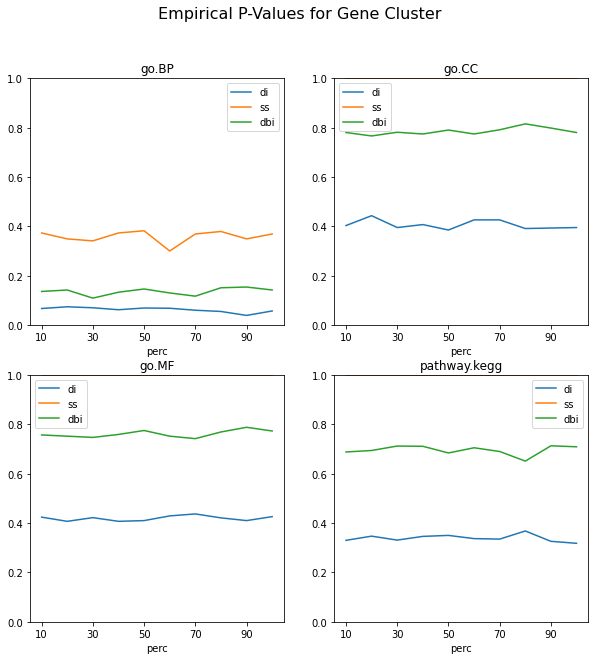

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Gene Cluster", fontsize=16)
plot_df[plot_df["attribute"]=="go.BP"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,0], title="go.BP")
plot_df[plot_df["attribute"]=="go.CC"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,1], title="go.CC")
plot_df[plot_df["attribute"]=="go.MF"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,0], title="go.MF")
plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")

<AxesSubplot:title={'center':'Davies Bouldin Index'}, xlabel='perc'>

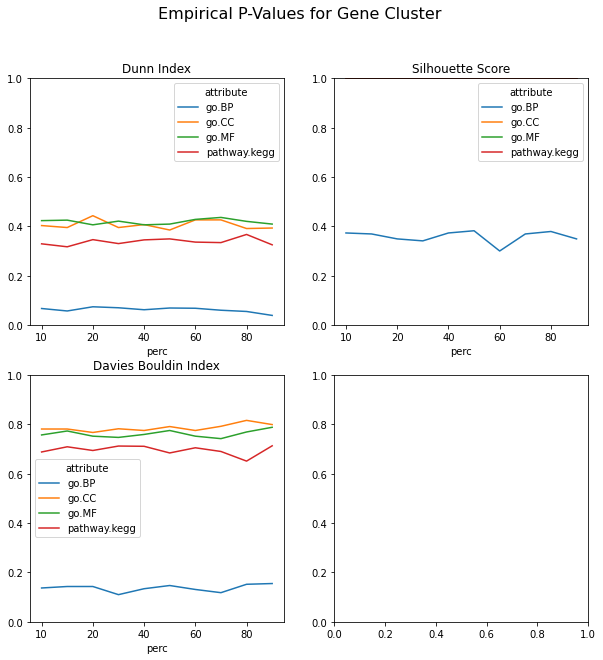

In [7]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Gene Cluster", fontsize=16)
plot_df.pivot(index='perc', columns='attribute', values='di').plot(ax=axes[0,0], title="Dunn Index")
plot_df.pivot(index='perc', columns='attribute', values='ss').plot(ax=axes[0,1], title="Silhouette Score")
plot_df.pivot(index='perc', columns='attribute', values='dbi').plot(ax=axes[1,0], title="Davies Bouldin Index")
#plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")


In [12]:
pd.DataFrame(results["10"]["input_values"])[["di","ss", "dbi"]]

,di,ss,dbi
go.BP,0.097523,-0.700000,0.180988
go.CC,0.181698,-1.000000,1.835614
go.MF,0.184877,-0.900000,1.962328
pathway.kegg,0.279293,-0.909091,0.275175


In [13]:
pd.DataFrame(results["10"]["input_values"]["ss_inter"])

,go.BP,go.CC,go.MF,pathway.kegg
0,-0.8,-1.0,-1.0,-1.0
1,-0.6,-1.0,-0.8,-0.8


In [37]:
atts = pd.read_csv("../mapping_files/gene_att_mapping.csv")
cluster = pd.read_csv(tar_set, sep="\t", header=None)
atts = atts[atts['entrezgene'].isin(cluster[0])].fillna("")
atts.head()

,entrezgene,go.CC,go.BP,go.MF,pathway.kegg
1417,51678,GO:0016020;GO:0005911;GO:0070062;GO:0005886,GO:0065003,GO:0005515,
3008,367,GO:0005634;GO:0005654;GO:0005829;GO:0032991;GO...,GO:0043568;GO:0000122;GO:0030521;GO:0045893;GO...,GO:0001223;GO:0005496;GO:0008013;GO:0004879;GO...,hsa05215;hsa05200;hsa04114
4492,399694,GO:0045211;GO:0005886,GO:0010468;GO:0035556;GO:0008284;GO:0007169;GO...,GO:0030971;GO:0019901;GO:0005515;GO:0019904,hsa04935;hsa04012;hsa04917;hsa05214;hsa05100;h...
4679,284467,GO:0005615,GO:1903980;GO:1902692;GO:1903979;GO:0014016;GO...,GO:0048018,
5702,5241,GO:0005654;GO:0005741;GO:0005829;GO:0000785,GO:0010629;GO:0002070;GO:0007267;GO:0038001;GO...,GO:0004879;GO:0019899;GO:0001223;GO:0008270;GO...,hsa04914;hsa04915;hsa04114;hsa05224


In [38]:
def string_to_len(x):
    return len(set(filter(None, x.split(";"))))
atts[atts.columns[1:]] = atts[atts.columns[1:]].applymap(string_to_len)

In [39]:
atts

,entrezgene,go.CC,go.BP,go.MF,pathway.kegg
1417,51678,4,1,1,0
3008,367,8,50,19,3
4492,399694,2,6,4,20
4679,284467,1,5,1,0
5702,5241,4,14,13,4
6248,3868,5,14,2,2
7332,56171,6,4,6,3
9281,1299,7,3,2,5
9725,8601,4,4,3,0
17355,10551,2,12,4,0


In [40]:
cluster.rename(columns={0:"id",1:"cluster"})

,id,cluster
0,8601,1
1,1956,1
2,547,1
3,399694,1
4,284467,1
5,51678,1
6,6280,1
7,1299,1
8,7545,1
9,3868,1


In [75]:
tar_set = "input/icd10_I-M_small.txt"
tar_id_type = "mondo"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [76]:
results2 = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results2[str(cur_perc)] = json.load(f)

[00:00:00|2736.09MB] Starting validation ...
[00:01:11|2736.09MB] Finished validation
[00:00:00|2736.09MB] Starting validation ...
[00:01:24|2736.09MB] Finished validation
[00:00:00|2736.09MB] Starting validation ...
[00:01:17|2736.28MB] Finished validation
[00:00:00|2736.28MB] Starting validation ...
[00:01:18|2736.28MB] Finished validation
[00:00:00|2736.28MB] Starting validation ...
[00:01:18|2736.28MB] Finished validation
[00:00:00|2736.28MB] Starting validation ...
[00:01:18|2737.53MB] Finished validation
[00:00:00|2737.53MB] Starting validation ...
[00:01:16|2740.78MB] Finished validation
[00:00:00|2740.78MB] Starting validation ...
[00:01:19|2740.53MB] Finished validation
[00:00:00|2740.53MB] Starting validation ...
[00:01:18|2740.53MB] Finished validation
[00:00:00|2740.53MB] Starting validation ...
[00:01:16|2740.78MB] Finished validation


In [77]:
plot_df = pd.DataFrame(columns=["attribute","di","ss","dbi","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results2[str(cur_perc)]["p_values"])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])

In [78]:
plot_df.head()

,attribute,di,ss,dbi,perc
0,disgenet.genes_related_to_disease,0.134865,0.474525,0.973027,10
1,disgenet.variants_related_to_disease,0.864136,0.984016,1.000000,10
2,ctd.pathway_related_to_disease,0.507493,0.926074,0.973027,10
0,disgenet.genes_related_to_disease,0.130869,0.496503,0.975025,20
1,disgenet.variants_related_to_disease,0.845155,0.977023,1.000000,20


In [81]:
plot_df["attribute"]

0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_disease
0       disgenet.genes_related_to_disease
1    disgenet.variants_related_to_disease
2          ctd.pathway_related_to_

<AxesSubplot:title={'center':'ctd.pathway_related_to_disease'}, xlabel='perc'>

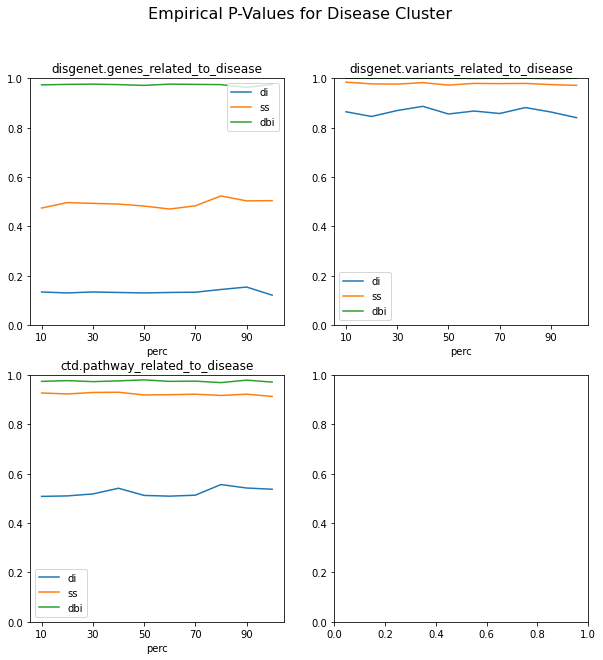

In [82]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df[plot_df["attribute"]=="disgenet.genes_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,0], title="disgenet.genes_related_to_disease")
plot_df[plot_df["attribute"]=="disgenet.variants_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,1], title="disgenet.variants_related_to_disease")
plot_df[plot_df["attribute"]=="ctd.pathway_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,0], title="ctd.pathway_related_to_disease")

<AxesSubplot:title={'center':'Davies Bouldin Index'}, xlabel='perc'>

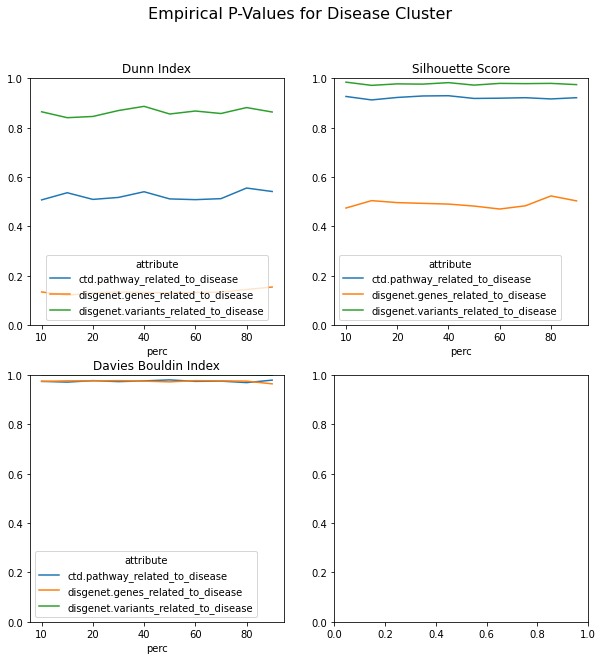

In [83]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df.pivot(index='perc', columns='attribute', values='di').plot(ax=axes[0,0], title="Dunn Index")
plot_df.pivot(index='perc', columns='attribute', values='ss').plot(ax=axes[0,1], title="Silhouette Score")
plot_df.pivot(index='perc', columns='attribute', values='dbi').plot(ax=axes[1,0], title="Davies Bouldin Index")
#plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")


In [84]:
tar_set = "input/mondo_cluster.txt"
tar_id_type = "mondo"
mode = "cluster"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [85]:
results3 = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results3[str(cur_perc)] = json.load(f)

[00:00:00|2740.78MB] Starting validation ...
[00:00:36|2746.78MB] Finished validation
[00:00:00|2746.78MB] Starting validation ...
[00:00:48|2746.37MB] Finished validation
[00:00:00|2746.37MB] Starting validation ...
[00:00:51|2746.73MB] Finished validation
[00:00:00|2746.73MB] Starting validation ...
[00:00:50|2746.48MB] Finished validation
[00:00:00|2746.48MB] Starting validation ...
[00:00:45|2746.48MB] Finished validation
[00:00:00|2746.48MB] Starting validation ...
[00:00:48|2746.23MB] Finished validation
[00:00:00|2746.23MB] Starting validation ...
[00:00:49|2745.97MB] Finished validation
[00:00:00|2745.97MB] Starting validation ...
[00:00:49|2746.38MB] Finished validation
[00:00:00|2746.38MB] Starting validation ...
[00:00:48|2746.40MB] Finished validation
[00:00:00|2746.40MB] Starting validation ...
[00:00:46|2747.63MB] Finished validation


In [91]:
plot_df = pd.DataFrame(columns=["attribute","di","ss","dbi","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results3[str(cur_perc)]["p_values"])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])

In [92]:
plot_df.head()

,attribute,di,ss,dbi,perc
0,disgenet.genes_related_to_disease,0.238761,0.729271,0.984016,10
1,disgenet.variants_related_to_disease,0.195804,0.871129,0.984016,10
2,ctd.pathway_related_to_disease,0.441558,0.176823,0.742258,10
0,disgenet.genes_related_to_disease,0.252747,0.699301,0.985015,20
1,disgenet.variants_related_to_disease,0.208791,0.851149,0.979021,20


<AxesSubplot:title={'center':'ctd.pathway_related_to_disease'}, xlabel='perc'>

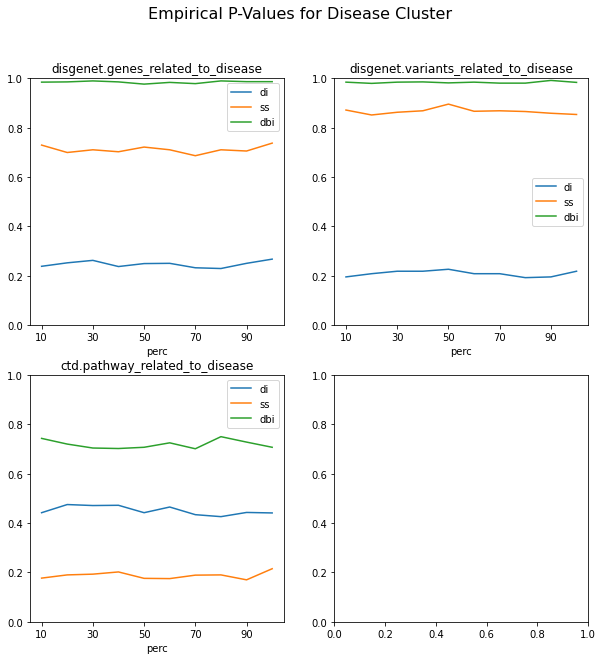

In [93]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df[plot_df["attribute"]=="disgenet.genes_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,0], title="disgenet.genes_related_to_disease")
plot_df[plot_df["attribute"]=="disgenet.variants_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[0,1], title="disgenet.variants_related_to_disease")
plot_df[plot_df["attribute"]=="ctd.pathway_related_to_disease"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,0], title="ctd.pathway_related_to_disease")

<AxesSubplot:title={'center':'Davies Bouldin Index'}, xlabel='perc'>

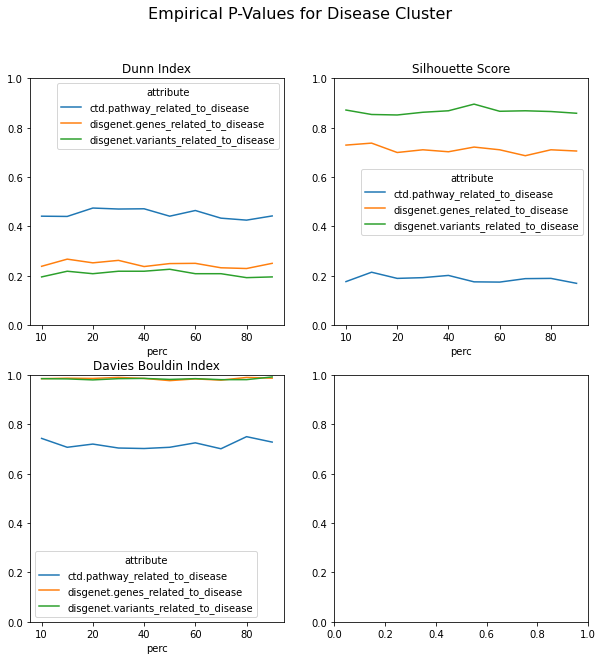

In [94]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10), subplot_kw={'ylim': (0,1)})
fig.suptitle("Empirical P-Values for Disease Cluster", fontsize=16)
plot_df.pivot(index='perc', columns='attribute', values='di').plot(ax=axes[0,0], title="Dunn Index")
plot_df.pivot(index='perc', columns='attribute', values='ss').plot(ax=axes[0,1], title="Silhouette Score")
plot_df.pivot(index='perc', columns='attribute', values='dbi').plot(ax=axes[1,0], title="Davies Bouldin Index")
#plot_df[plot_df["attribute"]=="pathway.kegg"].set_index('perc')[["di", "ss", "dbi"]].plot(ax=axes[1,1], title="pathway.kegg")


In [102]:
tar_set = "input/target_disease_set.txt"
tar_id_type = "ICD-10"
mode = "set"
out_dir = "results/"
runs = 1000
perc = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [103]:
results4 = dict()
for cur_perc in perc:
    single_validation(tar=tar_set, tar_id=tar_id_type, mode=mode, out_dir=out_dir, runs=runs, replace=cur_perc)
    with open(out_dir+'digest_'+mode+'_result.json', 'r') as f:
        results4[str(cur_perc)] = json.load(f)

[00:00:00|2989.54MB] Starting validation ...
[00:00:02|2989.59MB] Load distances for input into cache ...
[00:01:15|3015.94MB] Finished validation
[00:00:00|3015.94MB] Starting validation ...
[00:00:03|3016.20MB] Load distances for input into cache ...
[00:01:18|3016.98MB] Finished validation
[00:00:00|3016.98MB] Starting validation ...
[00:00:02|3016.98MB] Load distances for input into cache ...
[00:01:16|3017.23MB] Finished validation
[00:00:00|3017.23MB] Starting validation ...
[00:00:02|3007.82MB] Load distances for input into cache ...
[00:01:10|3007.88MB] Finished validation
[00:00:00|3007.88MB] Starting validation ...
[00:00:01|3009.23MB] Load distances for input into cache ...
[00:01:03|2942.51MB] Finished validation
[00:00:00|2942.51MB] Starting validation ...
[00:00:02|2979.23MB] Load distances for input into cache ...
[00:01:01|2979.30MB] Finished validation
[00:00:00|2979.30MB] Starting validation ...
[00:00:03|2981.77MB] Load distances for input into cache ...
[00:01:02|29

In [132]:
plot_df = pd.DataFrame(columns=["attribute","p_values","perc"])
for cur_perc in perc:
    df = pd.DataFrame.from_dict(results4[str(cur_perc)])
    df["perc"] = str(cur_perc)
    df = df.rename_axis('attribute').reset_index()
    plot_df = pd.concat([plot_df, df])
    plot_df = plot_df[["attribute","p_values","perc"]]

In [133]:
plot_df

,attribute,p_values,perc
0,disgenet.genes_related_to_disease,1.000000,10
1,disgenet.variants_related_to_disease,1.000000,10
2,ctd.pathway_related_to_disease,0.997003,10
0,disgenet.genes_related_to_disease,1.000000,20
1,disgenet.variants_related_to_disease,1.000000,20
2,ctd.pathway_related_to_disease,0.960040,20
0,disgenet.genes_related_to_disease,1.000000,30
1,disgenet.variants_related_to_disease,1.000000,30
2,ctd.pathway_related_to_disease,0.913087,30
0,disgenet.genes_related_to_disease,1.000000,40


In [129]:
pd.DataFrame(results4["10"])

,input_values,p_values
disgenet.genes_related_to_disease,7.732428,1.000000
disgenet.variants_related_to_disease,4.412785,1.000000
ctd.pathway_related_to_disease,1.003546,0.997003


In [105]:
plot_df

,attribute,di,ss,dbi,perc
0,disgenet.genes_related_to_disease,0.238761,0.729271,0.984016,10
1,disgenet.variants_related_to_disease,0.195804,0.871129,0.984016,10
2,ctd.pathway_related_to_disease,0.441558,0.176823,0.742258,10
0,disgenet.genes_related_to_disease,0.252747,0.699301,0.985015,20
1,disgenet.variants_related_to_disease,0.208791,0.851149,0.979021,20
2,ctd.pathway_related_to_disease,0.474525,0.189810,0.719281,20
0,disgenet.genes_related_to_disease,0.262737,0.710290,0.989011,30
1,disgenet.variants_related_to_disease,0.218781,0.862138,0.984016,30
2,ctd.pathway_related_to_disease,0.470529,0.192807,0.703297,30
0,disgenet.genes_related_to_disease,0.237762,0.702298,0.985015,40


In [114]:
pd.DataFrame(results2["10"]["input_values"])[["di","ss", "dbi"]]

,di,ss,dbi
disgenet.genes_related_to_disease,0.007588,-0.530196,11.104390
disgenet.variants_related_to_disease,0.000000,-0.143566,17.226517
ctd.pathway_related_to_disease,0.073855,-0.840604,8.930695


In [115]:
pd.DataFrame(results2["10"]["input_values"]["ss_inter"])

,disgenet.genes_related_to_disease,disgenet.variants_related_to_disease,ctd.pathway_related_to_disease
0,-0.737127,-0.762287,-0.89707
2,-0.142857,1.000000,-0.22125
3,-0.158339,0.500000,NaN
4,-0.704035,0.064932,-1.00000
1,-0.763104,-0.308298,-1.00000


In [116]:
pd.DataFrame(results3["10"]["input_values"])[["di","ss", "dbi"]]

,di,ss,dbi
disgenet.genes_related_to_disease,0.011838,-0.779331,2.074301
disgenet.variants_related_to_disease,0.008442,-0.429921,12.037512
ctd.pathway_related_to_disease,0.040552,-0.648143,2.959916


In [117]:
pd.DataFrame(results3["10"]["input_values"]["ss_inter"])

,disgenet.genes_related_to_disease,disgenet.variants_related_to_disease,ctd.pathway_related_to_disease
3,-0.717310,0.333333,-0.509614
2,-0.759644,-0.574406,-0.638069
1,-0.744289,-0.500000,-0.874992
0,-0.977985,-0.666279,0.000000


<AxesSubplot:title={'center':'Dunn Index'}, xlabel='perc'>

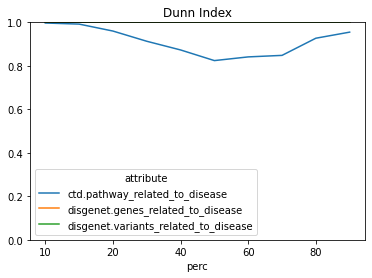

In [140]:
plot_df.pivot(index='perc', columns='attribute', values='p_values').plot(title="Dunn Index", ylim= (0,1))

In [146]:
pd.DataFrame(results4["10"]["input_values"].items())

,0,1
0,disgenet.genes_related_to_disease,7.732428
1,disgenet.variants_related_to_disease,4.412785
2,ctd.pathway_related_to_disease,1.003546


In [150]:
import scipy.sparse as sp
df = sp.load_npz("../mapping_files/disease_dist_rel_genes.npz").tocsr()

In [156]:
df = None

AttributeError: a not found